<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/symplectic_euler_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
#simplektik euler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

In [160]:
# Hamiltonian Equation

def T(p):
  return (p**2)/2

def V(q):
  return (q**2)/2

def H(q,p):
  return T(p) + V(q)

In [161]:
def dV(q_0=tf.constant(1.0)):
  q_0 = tf.constant(q_0)
  with tf.GradientTape() as g:
    g.watch(q_0)
    y = V(q_0)
  return g.gradient(y, q_0)

def dT(p_0=tf.constant(1.0)):
  p_0 = tf.constant(p_0)
  with tf.GradientTape() as g:
    g.watch(p_0)
    y = T(p_0)
  return g.gradient(y, p_0)

In [162]:
np.random.seed(1)
tf.random.set_seed(1)

def symplectic_euler(dT=dT, dV=dV ,h=0.5, initial_point= [0., 1.]):

    t = np.arange(0, 2*np.pi, h)

    q = np.zeros(t.shape[0])
    p = np.zeros(t.shape[0])

    q[0] = initial_point[0]
    p[0] = initial_point[1]
    
    for i in range(0, t.shape[0]-1):

      q[i + 1] = q[i] + h * dT(p[i])
      p[i + 1] = p[i] - h * dV(q[i+1])
    
    z = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)
    return z, t

In [163]:
z, t = symplectic_euler()
print("shape of q :", z[:,0].shape ,"\nshape of p:", z[:,1].shape, "\nsize of t:", len(t))


shape of q : (13,) 
shape of p: (13,) 
size of t: 13


In [164]:
def grand_truth_plot(h = 0.3):
  t = np.arange(0,2*np.pi,h)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.ylabel('p', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.title("Phase Diagram", fontsize=17,fontweight="bold",fontname="Times New Roman")

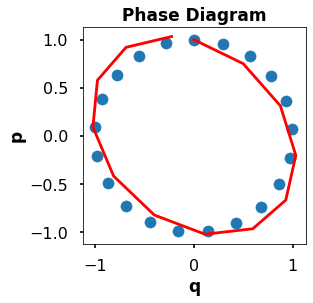

In [165]:
plt.figure(figsize = (4, 4))

# Simplectic solution plot
pred_plot(q=z[:,0], p=z[:,1])

# Grand truth solution plot
grand_truth_plot()
plt.show()

In [166]:
# NN input and target values
target = z[1:]
input_t = t[1:]

In [ ]:
"""
input_t = t.reshape(([input_t.shape[0],1]))
shuffle = np.concatenate((target,input_t), axis=1)
np.random.shuffle(shuffle)

target = shuffle[:,:2]
input_t = shuffle[:,2]
"""

In [152]:
np.random.seed(1)
tf.random.set_seed(1)

def NN(input =1, output=2, hidden_layer=2, neuron=32, activation="relu", energy_loss=None):
  # Neural network with MSE loss

  inp = Input(shape=(input,), name= "Input_Layer")
  for i in range(0,hidden_layer):
    if i == 0:
      x = Dense(neuron, activation="relu", name="Hidden_Layer_{}".format(i+1))(inp)
    else:
      x = Dense(neuron, activation="relu", name="Hidden_Layer_{}".format(i+1))(x)
  x = Dense(output, name="Ourput_Layer")(x)
  

  out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x

  return Model(inputs=inp, outputs=out)

In [153]:
model = NN(input= 1,output=2, hidden_layer=5, neuron=128, activation="relu")
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Hidden_Layer_1 (Dense)         (None, 128)          256         ['Input_Layer[0][0]']            
                                                                                                  
 Hidden_Layer_2 (Dense)         (None, 128)          16512       ['Hidden_Layer_1[0][0]']         
                                                                                                  
 tf.math.pow_11 (TFOpLambda)    (None, 1)            0           ['Input_Layer[0][0]']            
                                                                                           

In [139]:
"""
# Neural network with MSE loss
np.random.seed(1)
tf.random.set_seed(1)

inp = Input(shape=(1,))

x = Dense(32, activation="relu", name="hidden_layer_1")(inp)
x = Dense(32, activation="relu", name="hidden_layer_2")(x)
x = Dense(2)(x)

out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x

model = Model(inputs=inp, outputs=out)
model.summary()
"""

'\n# Neural network with MSE loss\nnp.random.seed(1)\ntf.random.set_seed(1)\n\ninp = Input(shape=(1,))\n\nx = Dense(32, activation="relu", name="hidden_layer_1")(inp)\nx = Dense(32, activation="relu", name="hidden_layer_2")(x)\nx = Dense(2)(x)\n\nout = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x\n\nmodel = Model(inputs=inp, outputs=out)\nmodel.summary()\n'

In [154]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss="mse")

model.fit(x=input_t, y=target, epochs=500, batch_size=16)

Epoch 1/500
4/4 [==============================] - 1s 7ms/step - loss: 0.9847
Epoch 2/500
4/4 [==============================] - 0s 5ms/step - loss: 0.6463
Epoch 3/500
4/4 [==============================] - 0s 5ms/step - loss: 0.6003
Epoch 4/500
4/4 [==============================] - 0s 5ms/step - loss: 0.5803
Epoch 5/500
4/4 [==============================] - 0s 5ms/step - loss: 0.5565
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 0.5382
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 0.5176
Epoch 8/500
4/4 [==============================] - 0s 6ms/step - loss: 0.5006
Epoch 9/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4884
Epoch 10/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4427
Epoch 11/500
4/4 [==============================] - 0s 5ms/step - loss: 0.4214
Epoch 12/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3754
Epoch 13/500
4/4 [==============================] - 0s 5ms/st

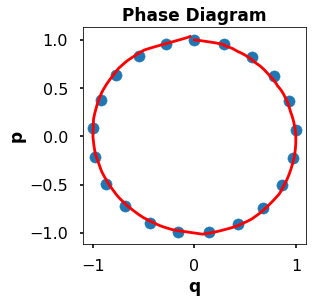

In [156]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction = model(test_t)

q = prediction[:,0]
p = prediction[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q, p )

# Grand truth solution plot
grand_truth_plot()

plt.show()

In [157]:
# Energy loss function
def custom_loss(y_true, y_pred):

  return tf.keras.losses.MSE(y_true, y_pred) + 20 * tf.keras.losses.MSE(0.5, H(y_pred))

In [158]:
energy_model = NN(input= 1,output=2, hidden_layer=5, neuron=128, activation="relu", energy_loss=custom_loss)
energy_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Hidden_Layer_1 (Dense)         (None, 128)          256         ['Input_Layer[0][0]']            
                                                                                                  
 Hidden_Layer_2 (Dense)         (None, 128)          16512       ['Hidden_Layer_1[0][0]']         
                                                                                                  
 tf.math.pow_12 (TFOpLambda)    (None, 1)            0           ['Input_Layer[0][0]']            
                                                                                           

In [ ]:
"""
# Neural network with Energy Preserved Loss
np.random.seed(1)
tf.random.set_seed(1)

inp_energy = Input(shape=(1,))

x_energy = Dense(512, activation="relu", name="hidden_layer_1")(inp_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_2")(x_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_3")(x_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_4")(x_energy)
x_energy = Dense(2)(x_energy)
out_energy = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp_energy**2)) * tf.matmul(x_energy, tf.constant([[0., -1.],[1., 0.]]))

model_energy = Model(inputs=inp_energy, outputs=out_energy)
model_energy.summary()
"""

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 hidden_layer_1 (Dense)         (None, 512)          1024        ['input_8[0][0]']                
                                                                                                  
 hidden_layer_2 (Dense)         (None, 512)          262656      ['hidden_layer_1[0][0]']         
                                                                                                  
 tf.math.pow_7 (TFOpLambda)     (None, 1)            0           ['input_8[0][0]']                
                                                                                            

In [ ]:
opt_energy = tf.keras.optimizers.Adam(learning_rate=0.001)

model_energy.compile(optimizer=opt_energy, loss=custom_loss)

model_energy.fit(x=input_t, y=target, epochs=4000, batch_size=64)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
20/20 [==============================] - 0s 7ms/step - loss: 7.6237e-05
Epoch 1502/4000
20/20 [==============================] - 0s 6ms/step - loss: 1.2483e-04
Epoch 1503/4000
20/20 [==============================] - 0s 6ms/step - loss: 5.4379e-05
Epoch 1504/4000
20/20 [==============================] - 0s 6ms/step - loss: 2.0387e-05
Epoch 1505/4000
20/20 [==============================] - 0s 6ms/step - loss: 1.0853e-05
Epoch 1506/4000
20/20 [==============================] - 0s 6ms/step - loss: 1.0930e-05
Epoch 1507/4000
20/20 [==============================] - 0s 5ms/step - loss: 9.3972e-06
Epoch 1508/4000
20/20 [==============================] - 0s 5ms/step - loss: 1.5755e-05
Epoch 1509/4000
20/20 [==============================] - 0s 7ms/step - loss: 1.5602e-05
Epoch 1510/4000
20/20 [==============================] - 0s 7ms/step - loss: 1.2906e-05
Epoch 1511/4000
20/20 [==============================] - 0s 7ms/step - loss: 1.0856e-05
E

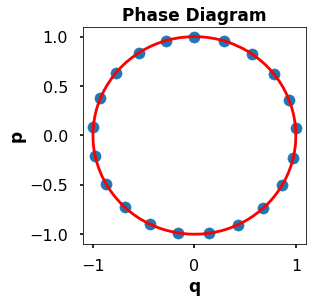

In [ ]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction_energy = model_energy(test_t)

q_energy = prediction_energy[:,0]
p_energy = prediction_energy[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q_energy, p_energy )

# Grand truth solution plot
grand_truth_plot()

plt.show()

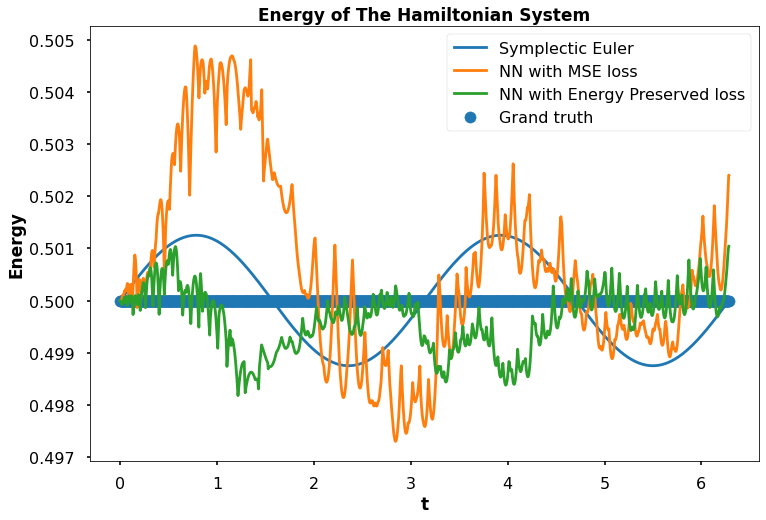

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(t, [0.5 for i in range(t.shape[0])], label="Grand truth")
plt.plot(t , H(z), label="Symplectic Euler")
plt.plot(test_t, H(model(test_t)), label="NN with MSE loss")
plt.plot(test_t, H(model_energy(test_t)), label="NN with Energy Preserved loss")

plt.title("Energy of The Hamiltonian System", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.xlabel("t", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.ylabel("Energy", fontsize=17, fontweight="bold", fontname="Times New Roman")
plt.legend(loc="upper right")
plt.show()

In [ ]:
grand_truth = np.concatenate((np.sin(t).reshape(-1,1), (np.cos(t).reshape(-1,1))), axis=1)

In [ ]:
z.shape

(1257, 2)

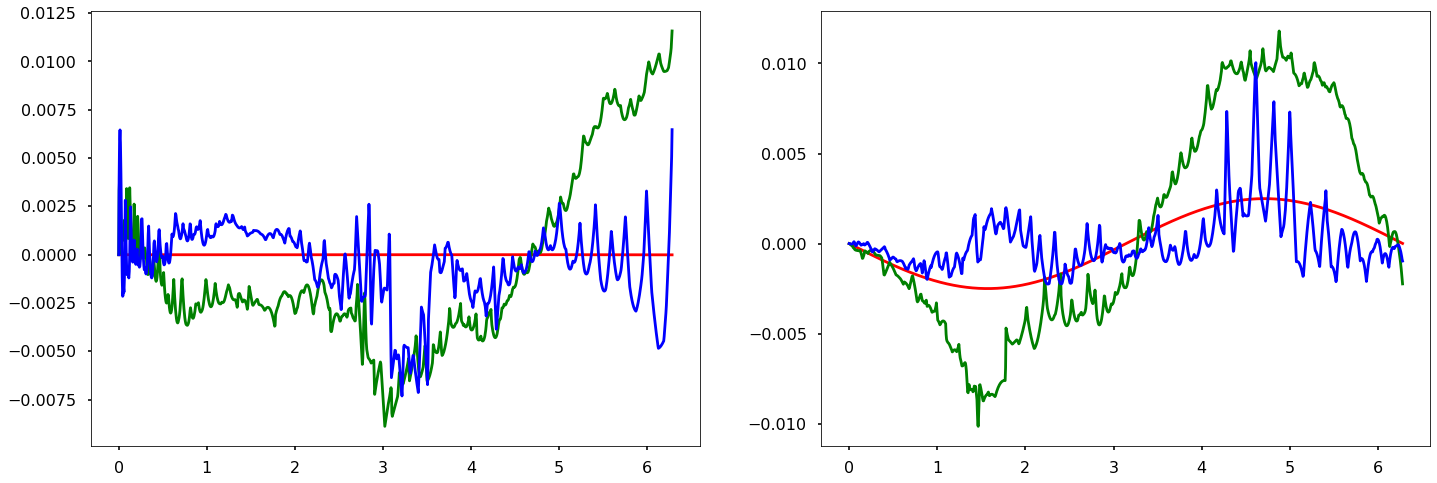

In [ ]:
# Symplectic
plt.figure(figsize=(24,8))

plt.subplot(121)
plt.plot(t, grand_truth[:,0] - z[:,0], c = 'r')
plt.plot(t, grand_truth[:,0] - model(t)[:,0], c= 'g')
plt.plot(t, grand_truth[:,0] - model_energy(t)[:,0] , c='b')

plt.subplot(122)
plt.plot(t, grand_truth[:,1] - z[:,1], c = 'r')
plt.plot(t, grand_truth[:,1] - model(t)[:,1], c= 'g')
plt.plot(t, grand_truth[:,1] - model_energy(t)[:,1] , c='b')